# Generate a Noise Model using Bootstrapping

Here we assume that we do not have access to calibration data to create a noise model for training DivNoising. In this case, we use an approach called ```Bootstrapping``` to create a noise model from noisy data itself. The idea is that we will first use the unsupervised denoising method Noise2Void to obtain denoised images corresponding to our noisy data. Then we will treat the denoised images as pseudo GT corresponding to the noisy data and use the pair of noisy images and corresponding Noise2Void denoised images to learn a noise model.

DivNoising when using bootstrapped noise model generally gives better results compared to Noise2Void denoising. Also, unlike Noise2Void, we additionally obtain diverse denoised samples corresponding to any noisy image unlike Noise2Void.

__Note:__ Denoising methods other than Noise2Void can also be used to obtain pseudo GT for bootsrapping a noise model.

In [15]:
import warnings
warnings.filterwarnings('ignore')
from tifffile import imread
import sys
sys.path.append('../../')
from divnoising.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from divnoising import histNoiseModel
from divnoising.utils import plotProbabilityDistribution

import torch
from careamics import CAREamist
from careamics.config import create_n2v_configuration

import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

dtype = torch.float
device = torch.device("cuda:0")

In [ ]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")

### Load SDTrans data

In [16]:
observation= imread('../../data/SDTrans/noise_200Hz_2400frames_pxlsize30nm_3.90dBSNR_24000x328x328.tif')
#Load the noisy data to be denoised

# load the first 1000 frames
observation = observation[:1000]
print(observation.shape)
print(observation.dtype)
print(type(observation))

(1000, 328, 328)
int16
<class 'numpy.ndarray'>


### Visualize the noisy data

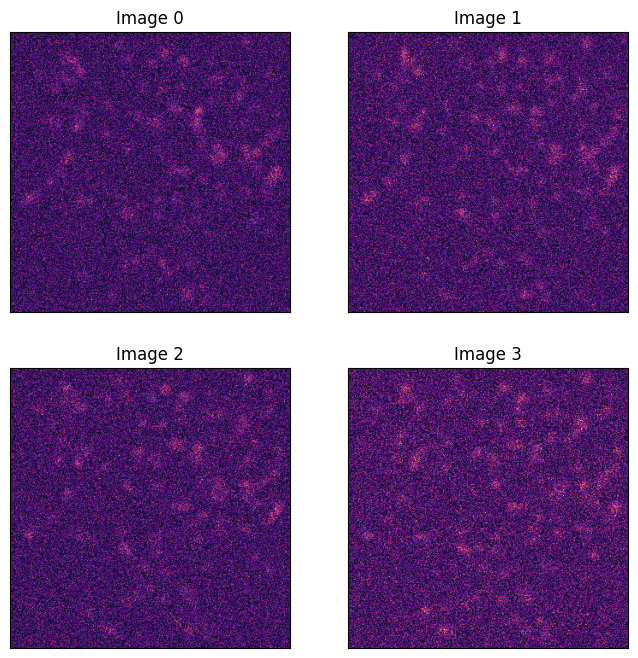

In [17]:
indices=[0,1,2,3]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(observation[indices[0]], cmap="magma")
ax[0, 0].set_title(f"Image {indices[0]}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(observation[indices[1]], cmap="magma")
ax[0, 1].set_title(f"Image {indices[1]}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(observation[indices[2]], cmap="magma")
ax[1, 0].set_title(f"Image {indices[2]}")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(observation[indices[3]], cmap="magma")
ax[1, 1].set_title(f"Image {indices[3]}")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

### Config the training settings

In [18]:
config = create_n2v_configuration(
    experiment_name="SDTrans_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(32, 32),
    batch_size=8,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                    

### Train the noise model

In [ ]:
# instantiate a CAREamist

careamist = CAREamist(source=config)

train_data=observation

# train
careamist.train(
    train_source=train_data,
)


### Figure the loss curve

In [ ]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

### Save the pseudo groundtruth

In [ ]:
from tifffile import imwrite
prediction = careamist.predict(source=train_data)

output_path = "prediction_result.tif"

imwrite("prediction_result.tif", prediction)


print(f"Saved multi-frame TIFF to {output_path}")

### Bulid the noise model Hist and GMM

In [ ]:
path = './data/Mouse_skull_nuclei/'
dataName = 'SDTrans' # Name of the noise model
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [ ]:
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'

In [ ]:


# read the prediction
signal = np.squeeze(tiff.imread("prediction_result.tif"))  # → (N,H,W)
print("Signal shape:", signal.shape)

#observation transfer to numpy and squeeze
try:
    observation_np = observation.cpu().numpy()
except:
    observation_np = observation

observation_np = np.squeeze(observation_np)
print("Observation shape:", observation_np.shape)

# indices
indices = [0, 1]

# Figure the plot
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i, idx in enumerate(indices):

    # Raw image
    ax[0, i].imshow(observation_np[idx], cmap="magma")
    ax[0, i].set_title(f"Raw {idx}")
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

    # Prediction (pseudo ground truth)
    ax[1, i].imshow(signal[idx], cmap="magma")
    ax[1, i].set_title(f"Pred {idx}")
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

plt.tight_layout()
plt.show()


### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [ ]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
print(observation.min(), observation.max())
print(signal.min(), signal.max())
minVal, maxVal = -200, 1900
bins = 400

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

In [ ]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [ ]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

In [ ]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Iterating the noise model training for `n_epoch=4000` and `batchSize=25000` works the best for `Mouse nuclei` dataset. 

In [ ]:
gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, 
                                                      path="", weight = None, n_gaussian = n_gaussian,
                                                      n_coeff = n_coeff, min_sigma = 50, device = device)

In [ ]:
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate=0.1, 
                                name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

### Visualizing the Histogram-based and GMM-based noise models

In [ ]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, 
                            gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, 
                            max_signal=maxVal, n_bin= bins, device=device)